# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 277.8 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 859.0 kB/s eta 0:00:0000:0100:01
  Using cached tqdm-4.64.1-py2.py3-none-any.whl (78 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 402.6 kB/s eta 0:00:00:--:--
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 442.7 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 392.2 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.2/776.3 MB 2.4 MB/s eta 0:04:16^C
     ━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.3/776.3 MB 2.3 MB/s eta 0:04:20
ERROR: Operation cancelled by user
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-dw3icra_
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-r

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


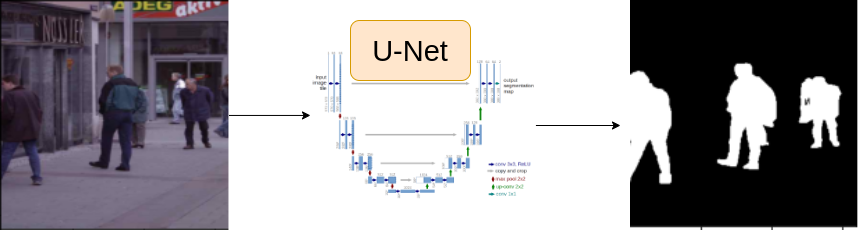

# Some Common Imports

In [1]:
import sys
sys.path.append('Human-Segmentation-Dataset-master')

In [2]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [3]:
CSV_FILE = 'Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '.'

DEVICE = 'cuda'
EPOCHS = 25
LR = 0.003
BATCH_SIZE = 16
IMG_SIZE = 320
ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'


In [4]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [5]:
row = df.iloc[3]
image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE) / 255.0

In [160]:
mask.shape

(401, 624)

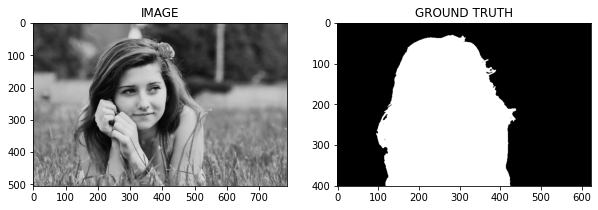

In [6]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [14]:
train_df, valid_df = train_test_split(df,test_size=0.2,random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [7]:
import albumentations as A

In [8]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE,IMG_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ])

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE,IMG_SIZE),
  ])

# Task 4 : Create Custom Dataset 

In [9]:
from torch.utils.data import Dataset

In [11]:
class SegmentationDataset(Dataset):
  def __init__(self,df,augmentations):
    self.df = df
    self.augmentations = augmentations
  
  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # (h,w,c)
    #print(mask.shape)
    mask = np.expand_dims(mask,axis = 2)
    #print(mask.shape,image.shape)
    if self.augmentations:
      data = self.augmentations(image = image,mask=mask)
      image = data['image']
      mask = data['mask']
    
    #(h,w,c)--> (c,h,w)
    image = np.transpose(image,(2,0,1)).astype(np.float32)
    mask = np.transpose(mask,(2,0,1)).astype(np.float32)

    image = torch.Tensor(image) /255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)
    return image,mask

In [12]:
image.shape

(505, 786, 3)

In [16]:
trainset = SegmentationDataset(train_df,get_train_augs())
validset = SegmentationDataset(valid_df,get_valid_augs())

In [18]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


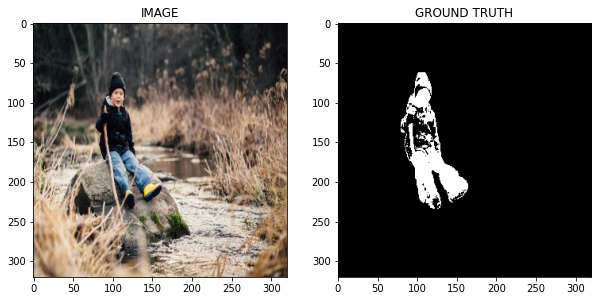

In [171]:
idx= 13

image,mask = trainset[idx]
helper.show_image(image,mask)

# Task 5 : Load dataset into batches

In [19]:
from torch.utils.data import DataLoader

In [20]:
trainLoader = DataLoader(trainset,batch_size=BATCH_SIZE,shuffle=True)
validLoader = DataLoader(validset,batch_size=BATCH_SIZE)

In [21]:
print(f"total no. of batch in tL :' {len(trainLoader)}")

total no. of batch in tL :' 15


In [22]:
for image,mask in trainLoader:
  break

print(f"One batch image shape:{image.shape}")
print(f"One batch mask shape:{mask.shape}")

One batch image shape:torch.Size([16, 3, 320, 320])
One batch mask shape:torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [23]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss



In [24]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel,self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self,images,masks=None):
    logits = self.arc(images)
    if mask != None:
      loss1 = DiceLoss(mode='binary')(logits,masks)
      loss2 = nn.BCEWithLogitsLoss()(logits,masks)
      return logits, loss1+loss2
    return logits

In [25]:
model = SegmentationModel()
model.to(DEVICE);

# Task 7 : Create Train and Validation Function 

In [26]:
def train_fn(data_loader,model,optimizer):
  model.train()
  total_loss = 0.0
  for images,masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)
    optimizer.zero_grad()
    logits,loss = model(images,masks)
    loss.backward()
    optimizer.step()

    total_loss+=loss.item()
  return total_loss/len(data_loader)

In [30]:
def eval_fn(data_loader,model):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images,masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)
      logits,loss = model(images,masks)


      total_loss+=loss.item()
  return total_loss/len(data_loader)

# Task 8 : Train Model

In [28]:
optimizer = torch.optim.Adam(model.parameters(),lr=LR)

In [ ]:
best_valid_loss = np.Inf
for i in range(EPOCHS):
  train_loss = train_fn(trainLoader,model,optimizer)
  valid_loss = eval_fn(validLoader,model)
  
  if valid_loss < best_valid_loss:
    torch.save(model.state_dict,'best_model.pt')
    print("MODEL SAVED")
    best_valid_loss = valid_loss
    print(f"Epouch : {i+1} Train_loss : {train_loss} Valid_loss : {valid_loss}")

100%|██████████| 4/4 [00:00<00:00,  4.80it/s]


MODEL SAVED
Epouch : 1 Train_loss : 0.38039883176485695 Valid_loss : 0.2984139434993267


100%|██████████| 4/4 [00:00<00:00,  5.00it/s]


MODEL SAVED
Epouch : 2 Train_loss : 0.28878726760546364 Valid_loss : 0.2604828290641308


100%|██████████| 4/4 [00:00<00:00,  4.91it/s]


MODEL SAVED
Epouch : 4 Train_loss : 0.24153836568196616 Valid_loss : 0.2510460168123245


100%|██████████| 4/4 [00:00<00:00,  4.93it/s]


MODEL SAVED
Epouch : 5 Train_loss : 0.22302340964476267 Valid_loss : 0.20676430687308311


100%|██████████| 4/4 [00:00<00:00,  4.92it/s]


MODEL SAVED
Epouch : 7 Train_loss : 0.2591819196939468 Valid_loss : 0.18940310552716255


100%|██████████| 4/4 [00:00<00:00,  4.86it/s]


MODEL SAVED
Epouch : 10 Train_loss : 0.15533147106568018 Valid_loss : 0.1595900095999241


100%|██████████| 4/4 [00:00<00:00,  4.89it/s]


# Task 9 : Inference

In [2]:
idx = 20

model.load_state_dict(torch.load('best_model.pt'))

image,mask = validset[idx]
logits_mask = model(image.to(DEVICE).unsqueeze(0)) #(C,H,W __> (1,C,H,W))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask>0.5)*1.0

"idx = 20\n\nmodel.load_state_dict(torch.load('/content/best_model.pt'))\n\nimage,mask = validset[idx]\nlogits_mask = model(image.to(DEVICE).unsqueeze(0)) #(C,H,W __> (1,C,H,W))\npred_mask = torch.sigmoid(logits_mask)\npred_mask = (pred_mask>0.5)*1.0"

In [ ]:
helper.show_image(image, mask,pred_mask.detach().cpu().squeeze0)